In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from datetime import datetime as dt
from cartopy.feature import OCEAN, LAND, BORDERS
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import r2_score

Can't find requested entry point: GDALRegisterMe
Can't find requested entry point: GDALRegister_nitf
Can't find requested entry point: GDALRegisterMe
Can't find requested entry point: GDALRegister_nitf


In [2]:
def animate(i):
    co2_i = co2_ppm.sel(time=times[i])
    array_i = co2_i.values.flatten()
    plt_co2.set_array(array_i)
    ax.set_title(times[i])

In [3]:
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-carbon-dioxide?tab=overview
# Data from Copernicus
co2_ds = xr.open_dataset(r'..\data\SAT_CO2_200301_201912_L3_OBS4MIPS.nc')

In [4]:
co2_ppm = co2_ds["xco2"] * 1e6

In [5]:
times = co2_ppm.time.to_dict()["data"]

In [6]:
cbar_kwargs = {'orientation':'horizontal', 
               'shrink':0.8, 
               'aspect':20, 
               "pad": 0.05,
               'label':'$CO_{2}$ Concentration (ppm)'}


In [7]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.3)
ax.add_feature(OCEAN, color="lavender")
ax.add_feature(LAND, color="oldlace")
ax.add_feature(BORDERS, 
            linestyle='-',
            lw=0.6,
            edgecolor='gray')
ax.gridlines(color='gray',
            alpha=0.6,
            draw_labels=True)

co2_2003 = co2_ppm.sel(time=times[0])
co2_2019 = co2_ppm.sel(time=times[-1])
vmin = float(co2_2003.min().data)
vmax = float(co2_2019.max().data)

plt_co2 = co2_ppm.sel(time=times[0]).plot(cmap='gist_heat_r', 
                                ax=ax,
                                vmin=vmin,
                                vmax=vmax,
                                robust=True,
                                cbar_kwargs=cbar_kwargs,
                                transform=ccrs.PlateCarree())

plt_co2.set_clim(vmin, vmax)
plt.tight_layout()
plt.close()

In [8]:
# Create the animation
animation = FuncAnimation(fig, animate, frames=len(times))
animation.save('06_Red.gif', dpi=150)

MovieWriter ffmpeg unavailable; using Pillow instead.


In [9]:
# Calculate the grids mean
co2_mean_glob = []
decimal_year = []
times = co2_ppm.time.to_dict()["data"]
for time in times:
    # Calculate the decimal date
    tdecimal = time.year + ((30.4375 * (time.month - 1) + time.day - 1) * 24 + time.hour)*3600/31557600.0 
    co2_mean_glob.append(float(co2_ppm.sel(time=time).mean().data))
    decimal_year.append(tdecimal)
decimal_year = np.array(decimal_year)
co2_mean_glob = np.array(co2_mean_glob)

In [10]:
# remove nan values
decimal_year_nonan = decimal_year[np.isfinite(co2_mean_glob)]
co2_mean_glob_nonan = co2_mean_glob[np.isfinite(co2_mean_glob)]

In [11]:
# Fit a quadratic trend line
coeffs = np.polyfit(decimal_year_nonan, co2_mean_glob_nonan, deg=2)

# Calculate the trend line
trend = []
for i, c in enumerate(co2_mean_glob):
    t_i = decimal_year[i] ** 2 * coeffs[0] + decimal_year[i] * coeffs[1] + coeffs[2]
    trend.append(t_i)
    
# Model
model = np.poly1d(coeffs)

# Calculate Rscore
rscore = r2_score(co2_mean_glob_nonan, model(decimal_year_nonan))
f"{round(rscore*100,2)}% of the variations is accounted for by the model"

'97.82% of the variations is accounted for by the model'

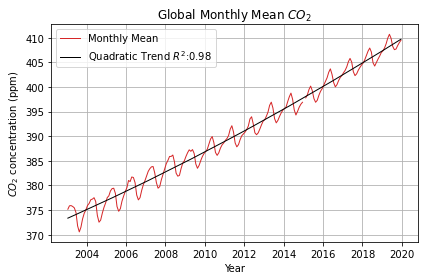

In [12]:
# Plot the result
fig, ax = plt.subplots()
ax.set_title("Global Monthly Mean $CO_{2}$")
ax.plot(times, co2_mean_glob, color="tab:red", lw=1)
ax.plot(times, trend, color="k", lw=1)
ax.set_xlabel("Year")
ax.set_ylabel("$CO_{2}$ concentration (ppm)")
ax.legend(["Monthly Mean", f"Quadratic Trend $R^{2}$:{round(rscore,2)}"])
ax.grid()
plt.tight_layout()